In [1]:
from dotenv import *
import os, subprocess
load_dotenv(find_dotenv())

project_root = '..'

In [2]:
query_path = os.path.join(project_root, os.environ['TARGET_QUERY_PATH'])

# Play the query

In [3]:
import IPython
IPython.display.Audio(query_path)

# What song was actually queried?

In [15]:
target_query_path = '00819.mid';
total_songs = len(os.listdir(os.path.join(project_root, os.environ['MIDI_DIR'])))

# Measure performance

In [16]:
%%time
from utils import get_prediction_df
res_df = get_prediction_df(query_path)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 2.75 s


In [17]:
import numpy as np
def get_rank(res_df, path):
    if len(res_df[res_df.midi_paths.str.contains(path)]) == 0:
        return -1
    return res_df.get_value(res_df[res_df.midi_paths.str.contains(path)].index[0], 'rank')

def get_error(res_df, path):
    if len(res_df[res_df.midi_paths.str.contains(path)]) == 0:
        return np.inf
    return res_df.get_value(res_df[res_df.midi_paths.str.contains(path)].index[0], 'error')

In [18]:
rank = get_rank(res_df, target_query_path)
print 'Ranked song %d out of %d' % (rank, total_songs)

Ranked song 41 out of 2048


# Measure performance with increasing noise

In [19]:
import librosa
y, sr = librosa.load(query_path, sr=8000)

In [20]:
from scipy.stats import signaltonoise
import numpy as np

def snr(y):
    return (10 * np.log10(np.abs(signaltonoise(y))))

init_snr = snr(y)
print 'SNR = %0.02f dB' % init_snr

SNR = -5.53 dB


In [21]:
import os, scipy
tmp_query_path = '.tmp_query.wav'
y_noise = y
snrs = [init_snr]
ranks = [rank]
dfs = [res_df]
errors = [get_error(res_df, target_query_path)]
iter_n = 0

while ranks[-1] != -1:
    iter_n += 1
    print iter_n
    y_noise = (y_noise + 0.2 * np.random.normal(0, 1, len(y))).astype('float16')
    
    scipy.io.wavfile.write(tmp_query_path, sr, y_noise)
    noise_df = get_prediction_df(tmp_query_path)
    noise_rank = get_rank(noise_df, target_query_path)
    
    dfs.append(noise_df)
    ranks.append(noise_rank)
    snrs.append(snr(y_noise))
    errors.append(get_error(noise_df, target_query_path))
       
os.remove(tmp_query_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [22]:
IPython.display.Audio(y_noise, rate=sr)

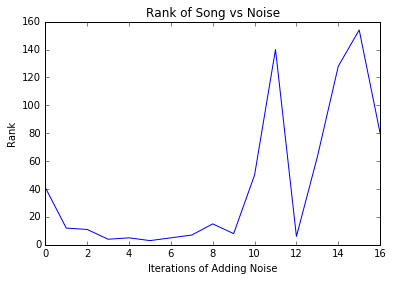

In [23]:
import matplotlib.pyplot as plt
y_ranks = ranks[:-1]
plt.plot(range(len(y_ranks)), y_ranks)
plt.ylabel('Rank')
plt.xlabel('Iterations of Adding Noise')
plt.title('Rank of Song vs Noise')

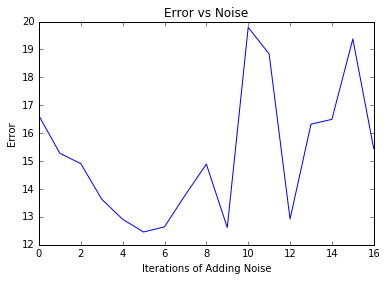

In [24]:
y_error = errors[:-1]
plt.plot(range(len(y_error)), y_error)
plt.ylabel('Error')
plt.xlabel('Iterations of Adding Noise')
plt.title('Error vs Noise')